In [1]:
#Defines the abstract class, 'Problem'. This is designed to be subclassed
class Problem(object):

    def __init__(self, initial, goal=None): #This constructor specifies the initial state and goal
        self.initial = initial
        self.goal = goal
        
    def is_in(self, element, sequence): #Checks the element is in the sequence
        return any(x is element for x in sequence)

    def actions(self, state): #Returns a list of actions that can be executed at the given state
        raise NotImplementedError

    def result(self, state, action): #Returns the state resulting from excecuting the given action
        raise NotImplementedError

    def goal_test(self, state): #Compares the state to the goal state, returns true if the state is a goal
        if isinstance(self.goal, list): #If the goal is a list of states, check that the given state is in one of those states
            return self.is_in(state, self.goal)
        else: #If the goal is a single state, compare the given state to the goal state
            return state == self.goal

    def path_cost(self, c, state1, action, state2): #Returns the cost of a solution path from state1 to state2 via action, given that the cost to reach state1 was c
        return c + 1 #c+1 is the default method, costing 1 for every step in the path. However, this was designed to be overriden

    def value(self, state): #For optimization problems, each state has a value
        raise NotImplementedError

In [2]:
#Defines the class, 'Node', which represents the node in a search tree
class Node:

    def __init__(self, state, parent=None, action=None, path_cost=0): #Creates a search tree node and sets up its basic attributes
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent: #If the node has a parent node, calculate the depth of the current node by adding 1 to the depth of the parent node.
            self.depth = parent.depth + 1

    def __lt__(self, node): #Compares nodes based on their states, this establishes order in the Node instances
        return self.state < node.state

    def expand(self, problem): #List the nodes reachable in one step from this node.
        return [self.child_node(problem, action) 
                for action in problem.actions(self.state)] #Iterates and generates a list of child nodes for each action
    
    def child_node(self, problem, action): #Creates the child nodes
        next_state = problem.result(self.state, action) #Calculates the next state by applying the given action to the current state using the problem's result method.
        next_node = Node(next_state, self, action, problem.path_cost(self.path_cost, self.state, action, next_state))  #Create a new child node using the calculated next state,the current node as the parent
        #the action that led from the parent to this state, and the total path cost from the initial state to this state.
        return next_node #Returns next_node

    def solution(self): # Return the sequence of actions from the root to this node.
        return [node.action for node in self.path()[1:]]

    def path(self): #Returns a list of nodes forming the path from the root to this node.
        node, path_back = self, [] #Sets the node variable to the current node and creates a list 'path_back', this will store the nodes from the root to the current node
        while node: #While node is not none, this loop iterates back through parent pointers of nodes until it reaches the root, which has no parent
            path_back.append(node) #Adds the current node to the path_back list
            node = node.parent #node is set to its parent 
        return list(reversed(path_back)) #Returns the path_back list

    #These two blocks of code prevent the duplication of states

    #Helps check whether a state has already been encountered
    def equal(self, other): #Checks if 'other' is an instance to the Node class and if both states are equal
        return isinstance(other, Node) and self.state == other.state #If both conditions are met, the nodes are equal, returning true
    
    def _hash_(self): #Compute the hash value of the state attribute of the node
        return hash(self.state) #If two nodes have the same state, they will produce the same hash value


In [3]:
import math
import numpy as np

In [4]:
#Subclass of the Problem class
class GraphProblem(Problem):

    def __init__(self, initial, goal, graph): #This constructor specifies a graph problem with the instance, initial state, goal state and the problem space 
        Problem.__init__(self, initial, goal) #Calls the parent constructor Problem.__init__
        self.graph = graph
        self.infinity=math.inf #Used to represent the inifinite path costs in the problem
        
    def euclidean_distance(self,a, b): #Calculates the Euclidean distance between two points
        xA, yA = a #The coordinates of point a
        xB, yB = b #The coordinates of point b
        return np.hypot((xA - xB), (yA - yB)) #Calculates the distance between a and b using the Numpy function
    
    def manhattan_distance(self, a, b): #Calculates the Manhattan distance between two points
        xA, yA = a #The coordinates of point a
        xB, yB = b #The coordinates of point b
        return abs(xA - xB) + abs(yA - yB) #Calculate Manhattan distance by summing absolute differences of coordinates
    
    def actions(self, A): #Returns a list of actions that can be executed at 'A' in the graph
        return list(self.graph.get(A).keys()) #Retrieves the neighbors of node A and returns it as a list

    def result(self, state, action): #Defines the result of taking an action from a given state.
        return action #Returns the action itself

    def path_cost(self, cost_so_far, A, action, B): #Calculates the total cost of reaching state B from state A
        return cost_so_far + (self.graph.get(A, B) or self.infinity)   

    def find_min_edge(self): #Finds the minimum value of edges in the graph
        m = self.infinity #Initializes m as infinity
        for d in self.graph.graph_dict.values(): #Iterates through the values of the graph dictionary
            local_min = min(d.values()) #Calculates the minimum edge cost stored in the dictionary
            m = min(m, local_min) #Updates the minimum value m by taking the minimum between the current value of m and the local_min 
        return m #Returns the minimum edge value found in the graph

    def h_euclidean(self, node): #Calculates the euclidean heuristic function
        locs = getattr(self.graph, 'locations', None) #Gets 'locations' from the self.graph object
        if locs: #Checks if locs exists
            if type(node) is str: #Check if the node is represented by a string
                #Calculates the euclidean distance between the node's location and the goal location using the euclidean_distance method
                return int(self.euclidean_distance(locs[node], locs[self.goal]))
            return int(self.euclidean_distance(locs[node.state], locs[self.goal]))
        else:
            return self.infinity #When locs = none, return infinity
        
    
    def h_manhattan(self, node): #Calculates the manhattan heuristic function
        locs = getattr(self.graph, 'locations', None) #Gets 'locations' from the self.graph object
        if locs: #Checks if locs exists
            if type(node) is str: #Checks if locs exists
                #Calculates the euclidean distance between the node's location and the goal location using the manhattan_distance method
                return int(self.manhattan_distance(locs[node], locs[self.goal]))
            return int(self.manhattan_distance(locs[node.state], locs[self.goal]))
        else:
            return self.infinity #When locs = none, return infinity 
    

In [5]:
#Creates a framework for an undirected graph. 
class Graph:

    def __init__(self, graph_dict=None, directed=True): #Constructor
        self.graph_dict = graph_dict or {} #Initializes 'graph_dict' as a dictionary
        self.directed = directed
        if not directed: #If the graph is not directed, then the graph is converted into an undirected graph 
            self.make_undirected() 

    def make_undirected(self): #Converts a directed graph into an undirected graph
        for a in list(self.graph_dict.keys()): #Iterates over each node 'a' in the graph
            for (b, dist) in self.graph_dict[a].items(): #Iterates over each edge 'b' in the graph
                self.connect1(b, a, dist) #This converts the converted edge from a and b into an undirected edge by adding symmetric edges

    def connect(self, A, B, distance=1): #Adds a link from A and B and adds the inverse link if the graph is undirected
        self.connect1(A, B, distance)
        if not self.directed:
            self.connect1(B, A, distance)

    def connect1(self, A, B, distance): #Adds a directed link from node A to B
        self.graph_dict.setdefault(A, {})[B] = distance

    def get(self, a, b=None): #Returns information about the distances between nodes in the graph. 
        links = self.graph_dict.setdefault(a, {}) #Retrieves the dictionary of connections from node 'a'
        if b is None:
            return links  # If 'b' is not provided, return node a's connections 
        else:
            return links.get(b) # If 'b' is provided, return the distance from node 'a' to node 'b'

    def nodes(self): #Return a list of all the nodes in the graph.
        s1 = set([k for k in self.graph_dict.keys()]) #s1 contains all the nodes from the graph_dict attribute of the Graph object
        s2 = set([k2 for v in self.graph_dict.values() for k2, v2 in v.items()]) #s2 contains all the nodes from the nested dictionaries inside graph_dict
        nodes = s1.union(s2) #Combine the sets
        return list(nodes) #Returns the list of nodes


def UndirectedGraph(graph_dict=None): #Build an undirected Graph where every edge goes both ways.
    return Graph(graph_dict=graph_dict, directed=False)

In [6]:
#Define Parkmore map as an undirected graph
#Its undirected but I thought it was easier to keep track of if I listed every link
Parkmore = UndirectedGraph(dict(
    Entry1=dict(Main_Entrance=1, Donut_King=1),#
    Entry2=dict(Main_Entrance=1, Bus_Stop=1, Shoe_Express=1),#
    Main_Entrance=dict(Entry1=1, Entry2=1, Bus_Stop=1, TRS_Discount_Store=1),#
    TRS_Discount_Store=dict(Main_Entrance=1, Kiosks1=1, Shoe_Express=1),#
    Shoe_Express=dict(Entry2=1, Kmart=1, Entry3=1, TRS_Discount_Store=1),#
    Kmart=dict(Shoe_Express=1, Escalators2=1),#
    Entry3=dict(Shoe_Express=1),#
    Kiosks1=dict(BigW=1, Kiosks2=2, Food_Court=1, TRS_Discount_Store=1),#
    BigW=dict(Kiosks1=1),#
    Food_Court=dict(Toilets=1, Donut_King=1, Kiosks1=1),#
    Toilets=dict(Food_Court=1),#
    Donut_King=dict(Entry1=1, Woolworths=1, Food_Court=1),#
    Woolworths=dict(Donut_King=1, Kiosks2=2),#
    Kiosks2=dict(Hairhouse_Warehouse=1, Kiosks1=2, Woolworths=2, Escalators=1, Coles=1, Entry5=2),#
    Hairhouse_Warehouse=dict(Specsavers=1, Kiosks2=1),#
    Specsavers=dict(Entry4=1, Hairhouse_Warehouse=1),#
    Entry4=dict(Specsavers=1),#
    Coles=dict(Escalators=1, Kiosks2=1, Coles_Entry2=1),#
    Escalators=dict(Coles=1, Kiosks2=1),#
    Entry5=dict(Kiosks2=2, Coles_Entry2=1),
    Coles_Entry2=dict(Entry5=1, Coles=1),#
    Bus_Stop=dict(Main_Entrance=1, Entry2=1), #
    Escalators2=dict(Kmart=1)
))


#Define the locations of each location in Parkmore
Parkmore.locations = dict(
    Entry1=(15.2, 4.5),
    Entry2=(19.8, 5),
    Main_Entrance=(17.5 ,5.5),
    TRS_Discount_Store=(18.2, 6.8),
    Shoe_Express=(20, 6.2),
    Kmart=(21.1, 5.9),
    Entry3=(20.8, 7.9),
    Kiosks1=(15.8, 6.9),
    BigW=(16.1, 7.9),
    Food_Court=(15.5, 6),
    Toilets=(15.7, 5.5),
    Donut_King=(14.2, 5.7),
    Woolworths=(13.1, 5.2),
    Kiosks2=(11.9, 7.8),
    Hairhouse_Warehouse=(12.2, 8.5),
    Specsavers=(11.4, 9.2),
    Entry4=(10.4, 10.8),
    Coles=(10.7, 8),
    Escalators=(10.7, 7.5),
    Entry5=(8.5, 6),
    Coles_Entry2=(6.8, 8.1),
    Bus_Stop=(17.5, 3.2),
    Escalators2=(21.1, 6.3)
)

#Note the escalators are sloped and lock onto wheels, so as long as there's someone accompanying the wheelchair rider, it should be fine to go on

In [7]:
Parkmore_locations = Parkmore.locations #Prints the locations in Parkmore
print(Parkmore_locations)

{'Entry1': (15.2, 4.5), 'Entry2': (19.8, 5), 'Main_Entrance': (17.5, 5.5), 'TRS_Discount_Store': (18.2, 6.8), 'Shoe_Express': (20, 6.2), 'Kmart': (21.1, 5.9), 'Entry3': (20.8, 7.9), 'Kiosks1': (15.8, 6.9), 'BigW': (16.1, 7.9), 'Food_Court': (15.5, 6), 'Toilets': (15.7, 5.5), 'Donut_King': (14.2, 5.7), 'Woolworths': (13.1, 5.2), 'Kiosks2': (11.9, 7.8), 'Hairhouse_Warehouse': (12.2, 8.5), 'Specsavers': (11.4, 9.2), 'Entry4': (10.4, 10.8), 'Coles': (10.7, 8), 'Escalators': (10.7, 7.5), 'Entry5': (8.5, 6), 'Coles_Entry2': (6.8, 8.1), 'Bus_Stop': (17.5, 3.2), 'Escalators2': (21.1, 6.3)}


In [8]:
# node colors, node positions and node label positions
node_colors = {node: 'white' for node in Parkmore.locations.keys()} #All nodes are initially set to white
node_positions = Parkmore.locations #Stores the coordinates for each node in the graph
node_label_pos = { k:[v[0],v[1]-10]  for k,v in Parkmore.locations.items() } #Defines the positions of node labels
edge_weights = {(k, k2) : v2 for k, v in Parkmore.graph_dict.items() for k2, v2 in v.items()} #Stores the distances of each edge in the graph 

Parkmore_graph_data = {  'graph_dict' : Parkmore.graph_dict, #Combines all the data into a single dictionary 'Parkmore_graph_data'
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                         'edge_weights': edge_weights
                     }

In [9]:
#Creates a map

%matplotlib inline 
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import lines

from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
import time


def show_map(graph_data, node_colors=None):
    G = nx.Graph(graph_data['graph_dict']) #Initializes a NetworkX graph using the graph dictionary stored in graph_data
    node_colors = node_colors or graph_data['node_colors']
    node_positions = graph_data['node_positions']
    node_label_pos = graph_data['node_label_positions']
    edge_weights = graph_data['edge_weights']

    
    plt.figure(figsize=(20, 7)) #Sets the size of the plot
    nx.draw(G, pos={k: node_positions[k] for k in G.nodes()}, #Draws the graph (both nodes and edges) with locations
            node_color=[node_colors[node] for node in G.nodes()], linewidths=0.3, edgecolors='k',with_labels = True)

    # Add edge lables to the graph
    nx.draw_networkx_edge_labels(G, pos=node_positions, edge_labels=edge_weights, font_size=14)

    #Adds legend
    white_circle = lines.Line2D([], [], color="white", marker='o', markersize=15, markerfacecolor="white")
    orange_circle = lines.Line2D([], [], color="orange", marker='o', markersize=15, markerfacecolor="orange")
    red_circle = lines.Line2D([], [], color="red", marker='o', markersize=15, markerfacecolor="red")
    gray_circle = lines.Line2D([], [], color="gray", marker='o', markersize=15, markerfacecolor="gray")
    green_circle = lines.Line2D([], [], color="green", marker='o', markersize=15, markerfacecolor="green")
    plt.legend((white_circle, orange_circle, red_circle, gray_circle, green_circle),
               ('Un-explored', 'Frontier', 'Currently Exploring', 'Explored', 'Final Solution'),
               numpoints=1, prop={'size': 16}, loc=(.9, .75))

    #Shows the plot
    plt.show()

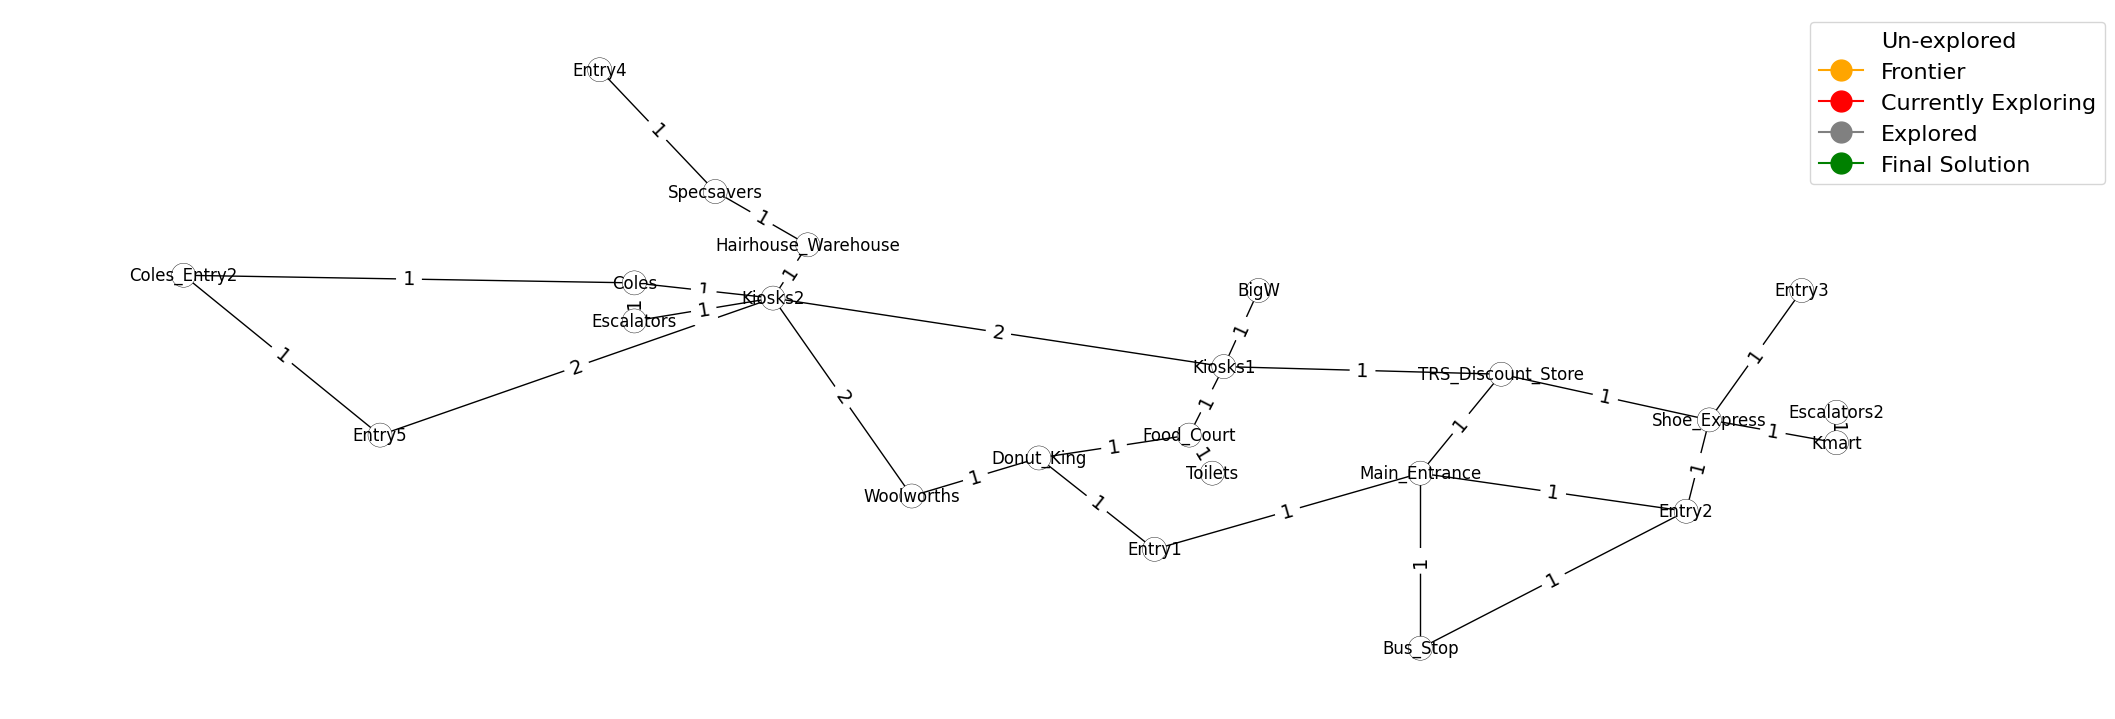

In [10]:
show_map(Parkmore_graph_data) #Displays map

In [11]:
import heapq

In [12]:
import functools

In [13]:
def final_path_colors(initial_node_colors, problem, solution):
    "Return a node_colors dict of the final path provided the problem and solution."

    #Get initial node colors
    final_colors = dict(initial_node_colors)
    
    #Color all the nodes in the solution path and starting node to green
    final_colors[problem.initial] = "green" #Colours the initial node to green
    for node in solution: #Iterates over each node in the solution path
        final_colors[node] = "green" #Colour each node green
    return final_colors #Return the node colours in the final path

#Controls the visualization of search algorithms on a graph
def display_visual(graph_data, user_input, algorithm=None, problem=None):
    initial_node_colors = graph_data['node_colors'] #Get initial node colours from the graph data
    if user_input is False: #Checks if user input is false
        def slider_callback(iteration): 
            try: #Displays the map using the show_map function
                show_map(graph_data, node_colors=all_node_colors[iteration]) 
            except: #Exception handling
                pass

        def visualize_callback(visualize):
            if visualize is True: #Checks if the visualize toggle button is set to True
                button.value = False #Resets the button value to False to prevent multiple executions

                global all_node_colors #Defines the all_node_colors variable as global
                
                #Calls algorithm(problem) which executes the A* search algorithm
                iterations, all_node_colors, node = algorithm(problem) #Returns iterations, all_node_colors and node
                solution = node.solution() #Stores the whole solution path to solution
                #Adds the colors of nodes in the solution path to the all_node_colors list.
                all_node_colors.append(final_path_colors(all_node_colors[0], problem, solution)) 

                #Set the maximum value of the slider to the number of iterations minus 1
                slider.max = len(all_node_colors) - 1

                # Iterate over each iteration from 0 to the maximum iteration value
                for i in range(slider.max + 1):
                    slider.value = i #Set the value of the slider to the current iteration
                    time.sleep(.5) #Pauses for half a second for each iteration

        slider = widgets.IntSlider(min=0, max=1, step=1, value=0) #Create an integer slider widget
        slider_visual = widgets.interactive(slider_callback, iteration=slider) #Create an interactive widget that calls slider_callback function
        display(slider_visual) #Display the slider widget

        #When the toggle button is pressed value=True
        button = widgets.ToggleButton(value=False) #Creates a toggle button with an intitial value of false
        button_visual = widgets.interactive(visualize_callback, visualize=button) #Creates an interactive widget
        display(button_visual) #Displays the interactive button





In [14]:
class PriorityQueue:
    
    def __init__(self, order='min', f=lambda x: x): #Initializes a PriorityQueue instance
        self.heap = [] #Initialize empty list
        if order == 'min': #Order specifies whether PriorityQueue should be min or max
            self.f = f #Set self.f to f
        elif order == 'max':  
            self.f = lambda x: -f(x)  #f maps elements of the priority queue to their priority values
        else:
            raise ValueError("Order must be either 'min' or 'max'.") #Value must be min or max

    def append(self, item): #Insert item at its correct position in the priority queue
        heapq.heappush(self.heap, (self.f(item), item))

    def extend(self, items): #Inserts each item at its correct position in the queue
        for item in items:
            self.append(item)

    #Selects a node to currently explore
    def pop(self): #Removes and returns the item with the highest or lowest priority depending on the order of the queue
        if self.heap:
            return heapq.heappop(self.heap)[1]
        else:
            raise Exception('Trying to pop from empty PriorityQueue.')

    def __len__(self): #Returns the current capacity of the queue
        return len(self.heap)

    def __contains__(self, key): #Return True if the key is in PriorityQueue
        return any([item == key for _, item in self.heap])

    def __getitem__(self, key): #Returns the first value associated with key in the queue. If key is not present, a KeyError is raised.
        for value, item in self.heap:
            if item == key:
                return value
        raise KeyError(str(key) + " is not in the priority queue")

    def __delitem__(self, key): #Deletes the first occurrence of key in the queue. If key is not present, a KeyError is raised.
        try:
            del self.heap[[item == key for _, item in self.heap].index(True)]
        except ValueError:
            raise KeyError(str(key) + " is not in the priority queue")
        heapq.heapify(self.heap)

In [15]:
import functools

def memoize(fn, slot=None, maxsize=32): #Stores the computed value for any argument list

    #Define the memoized function that will be returned
    if slot:
        def memoized_fn(obj, *args):
            #If the object has a slot with the specified name, return its value
            if hasattr(obj, slot):
                return getattr(obj, slot)
            #Otherwise, compute the value of fn and store it in the slot
            else:
                val = fn(obj, *args)
                setattr(obj, slot, val)
                return val
    else:
        # Use the lru_cache decorator to cache the values
        @functools.lru_cache(maxsize=maxsize)
        def memoized_fn(*args):
            return fn(*args)

    # Return the memoized function
    return memoized_fn


In [16]:
def best_first_graph_search_for_vis(problem, f):

    #Initialize visualisation variables
    iterations = 0
    all_node_colors = [] #List to store node colours
    node_colors = {k : 'white' for k in problem.graph.nodes()} #All the nodes start off as white

    node = Node(problem.initial) #Creates the initial node

    
    node_colors[node.state] = "red" #Color the initial node as red
    iterations += 1 #Increments iterations by 1
    all_node_colors.append(dict(node_colors)) #Adds the node to the all_node_colors list

    
    if problem.goal_test(node.state): #Check if the initial state is the goal state
        node_colors[node.state] = "green" #Colors the initial node green
        iterations += 1 #Increments iterations by 1
        all_node_colors.append(dict(node_colors)) #Adds the current nodes colors to the all_node_colors list
        return(iterations, all_node_colors, node)

    frontier = PriorityQueue('min', f) #Nodes with lower f scores are explored first
    frontier.append(node) #Add the nodes to the frontier

    node_colors[node.state] = "orange" #Set the color of the current node to orange, indicating it's in the frontier
    iterations += 1 #Increments iterations by 1
    all_node_colors.append(dict(node_colors)) #Add the current nodes to all_node_colors

    explored = set() #Initialize an empty set to keep track of explored states
    while frontier: #Continue the loop as long as there are nodes in the frontier
        node = frontier.pop() #Explores the frontier node

        node_colors[node.state] = "red"  #Set the color of the current node to red, indicating it's getting explored
        iterations += 1 #Increments iterations by 1
        all_node_colors.append(dict(node_colors)) #Add the current nodes to all_node_colors

        
        if problem.goal_test(node.state): #Check if the current node is a goal state
            node_colors[node.state] = "green" #Color the node as green to indicate it is a goal state
            iterations += 1 #Increment the iteration count
            all_node_colors.append(dict(node_colors)) #Add the current nodes to all_node_colors
            return(iterations, all_node_colors, node)

        explored.add(node.state) #Add the current node to the set of explored states
        for child in node.expand(problem): #Iterate over the child nodes of the current node
            if child.state not in explored and child not in frontier: #Check if the child node has not been explored and is not in the frontier
                frontier.append(child) #Add the child node to the frontier
                incumbent = frontier[child] #the currently best-known solution node-incumbent
                node_colors[child.state] = "orange" #Color the child node as orange to indicate it's in the frontier
                iterations += 1 #Increment the iteration count
                all_node_colors.append(dict(node_colors)) #Add the current nodes to all_node_color
            elif child in frontier: #Checks if the child node is already in the frontier
                if f(child) < incumbent: #If the new path to the child node has a lower cost than the incumbent
                    del frontier[child] #Remove the incumbent from the frontier
                    frontier.append(child) #Add the child node to the frontier
                    node_colors[child.state] = "orange" #Color the child node as orange to indicate it's in the frontier
                    iterations += 1 #Increments iterations by 1
                    all_node_colors.append(dict(node_colors)) #Add the current nodes to all_node_colors

        node_colors[node.state] = "gray" #Set the color of the current node to gray, indicating it has been already explored
        iterations += 1 #Increment the iteration count
        all_node_colors.append(dict(node_colors)) #Add the current nodes to all_node_colors
    return None #Returns none if the search does not find a solution

In [20]:
def euclidean_astar_search(problem, h=None): #This uses the function h_euclidean
    #To use manhattan distance, call problem.h_manhattan instead of problem.h_euclidean
    h = memoize(h or problem.h_euclidean, 'h') #Memoize the heuristic function h
    #Calls best_first_graph_search_for_vis with f(n) = g(n) + h(n)
    iterations, all_node_colors, node = best_first_graph_search_for_vis(problem,lambda node: node.path_cost + h(node)) 
    return(iterations, all_node_colors, node) #Returns the number of iterations, node colors and the final node

In [21]:
all_node_colors = [] #Initializes a list all_node_colours
#Create a problem instance for the Parkmore graph
Parkmore_problem = GraphProblem('Bus_Stop', 'Entry4', Parkmore)
#Display the visualization of the Parkmore graph search
display_visual(Parkmore_graph_data, user_input=False,
               algorithm=euclidean_astar_search,
               problem=Parkmore_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

In [22]:
def manhattan_astar_search(problem, h=None): #This uses the function h_euclidean
    #To use manhattan distance, call problem.h_manhattan instead of problem.h_euclidean
    h = memoize(h or problem.h_manhattan, 'h') #Memoize the heuristic function h
    #Calls best_first_graph_search_for_vis with f(n) = g(n) + h(n)
    iterations, all_node_colors, node = best_first_graph_search_for_vis(problem,lambda node: node.path_cost + h(node)) 
    return(iterations, all_node_colors, node) #Returns the number of iterations, node colors and the final node

In [23]:
all_node_colors = [] #Initializes a list all_node_colours
#Create a problem instance for the Parkmore graph
Parkmore_problem = GraphProblem('Bus_Stop', 'Entry4', Parkmore)
#Display the visualization of the Parkmore graph search
display_visual(Parkmore_graph_data, user_input=False,
               algorithm=manhattan_astar_search,
               problem=Parkmore_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…